In [1]:
#%matplotlib notebook
#import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import os, os.path
import glob
import h5py
import pickle
import numpy as np
import pynbody
from numpy.polynomial import Polynomial
from mpl_toolkits import mplot3d
from scipy import ndimage, signal, interpolate
from astropy.coordinates import SkyCoord,Galactic,ICRS,Galactocentric
import astropy.coordinates as coord
from galpy.potential import NFWPotential,DoubleExponentialDiskPotential,MN3ExponentialDiskPotential,HernquistPotential,ChandrasekharDynamicalFrictionForce
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014,MiyamotoNagaiPotential
from galpy.util import conversion, save_pickles, coords, plot
#import seaborn as sns
from matplotlib import animation
from scipy.stats import gaussian_kde
import astropy.units as u
from scipy.interpolate import interpn
from galpy import potential
from gizmo_util import *

'''
read_snapshot,
extract_data_of_ptype,
make_IC,
make_gizmo_IC,
Gizmo_to_pynbody
compute_surface_density
find_centre_of_density
find_centre
align_stream
'''

#from matplotlib import cm, pyplot
from galpy.potential import evaluatezforces

coord.galactocentric_frame_defaults.set('v4.0') 

<ScienceState galactocentric_frame_defaults: {'galcen_coord': <ICRS Coordinate: (ra, dec) in deg...>

Define useful functions

In [2]:
def galcencyl_to_lbd(R,phi,Z,degree=True):
        xyz=bovy_coords.galcencyl_to_XYZ(R,phi,Z)
        l=[]
        b=[]
        d=[]
        for ii in range(len(xyz)):
            lbd=bovy_coords.XYZ_to_lbd(xyz[ii][0],xyz[ii][1],xyz[ii][2],degree=degree)
            l.append(lbd[0])
            b.append(lbd[1])
            d.append(lbd[2])
            
        return (l,b,d)
    
def compute_ndenp1(p1,Nbins=50,polydeg=3):
    
    phi1_bins = np.linspace(p1.min(),p1.max(),Nbins)
    phi1_mid = [0.5*(phi1_bins[ii]+phi1_bins[ii+1]) for ii in range(len(phi1_bins)-1)]
    print ("bin width = %.2f"%(phi1_bins[1]-phi1_bins[0]))
        
    Ndn=np.histogram(p1,phi1_bins)[0]
    print (np.sum(Ndn))
    Ndn_err=np.sqrt(Ndn)
       
    pp= Polynomial.fit(phi1_mid,Ndn,deg=polydeg,w=1/(Ndn_err))
    nden=Ndn/pp(np.array(phi1_mid))
    nden_err=np.sqrt(Ndn)/pp(np.array(phi1_mid))
        
    return (phi1_mid,Ndn,Ndn_err,nden,nden_err,pp(np.array(phi1_mid)))



def compute_Pk(p1,nden,nden_err, scaling = 'spectrum'):
      
    
    px,py= signal.csd(nden,nden,fs=1./(p1[1]-p1[0]),scaling=scaling,nperseg=len(p1))
    py= py.real
    px= 1./px
    py= np.sqrt(py*(p1[-1]-p1[0]))
              
    # Perform simulations of the noise to determine the power in the noise
    nerrsim= 10000
    ppy_err= np.empty((nerrsim,len(px)))
    for ii in range(nerrsim):
        tmock= nden_err*np.random.normal(size=len(p1))
        ppy_err[ii]= signal.csd(tmock,tmock,
                                fs=1./(p1[1]-p1[0]),scaling=scaling,
                                nperseg=len(p1))[1].real
    py_err= np.sqrt(np.median(ppy_err,axis=0)*(p1[-1]-p1[0]))
    
    #return 180./px/numpy.pi, py, py_err #if apars
    return px, py, py_err

#power spectrum from dens already converted to observed coordinates
def compute_pk_scatter(fname,N,scatter=False,scaling='spectrum'):
    
    data=np.loadtxt(fname,delimiter=',')
    p1 = data[0]
    dens = data[1]
    px,py= signal.csd(dens,dens,fs=1./(p1[1]-p1[0]),scaling='spectrum',nperseg=len(p1))
    py= py.real
       
    ppy= np.empty((N,len(px)))
         
    for ii in range(1,N):
        py= signal.csd(data[ii],data[ii],fs=1./(p1[1]-p1[0]),scaling='spectrum',nperseg=len(p1))[1].real
        ppy[ii]=py
    
    if not scatter:
        return (1./px,np.sqrt(np.nanmedian(ppy,axis=0)*(p1[-1]-p1[0])))
        
    else:
        out= np.sqrt(np.nanmedian(ppy,axis=0)*np.abs(p1[-1]-p1[0]))
                
        ppy.sort(axis=0)
        
        return (1./px,out,
                np.sqrt(ppy[int(np.round(0.023*N))]*(p1[-1]-p1[0])),
                np.sqrt(ppy[int(np.round(0.977*N)-1)]*(p1[-1]-p1[0])))
                #np.sqrt(ppy[int(np.round(0.159*N))]*(ll[-1]-ll[0])),
                #np.sqrt(ppy[int(np.round(0.84*N)-2)]*(ll[-1]-ll[0])))
                



### Analyze the $10^{5} \ \rm{M}_{\odot}$ resolution case
Halo particle softening = 0.2 kpc \
cluster particle softening = 2 pc \
Analytic disk from MWPotential2014 used.

In [3]:
dir1 = "../Gizmo/ics/GD1_inMcMillanHaloVelFlipped_Mres1e5_Disk_N100W7R20_forward_integrate/"

mm = 400
mm_shift = 0

tt4,id4,x4,y4,z4,vx4,vy4,vz4,m4 = extract_data_of_ptype(folder=dir1,ptype=4,nfiles=mm,shift_file_ind=mm_shift,shift_ID=0,pot_acc=False)

In [4]:
o= Orbit.from_name("GD1")

c1 = coord.ICRS(ra=o.ra()*u.degree, dec=o.dec()*u.degree,
                distance=o.dist()*u.kpc,
                pm_ra_cosdec=o.pmra()*u.mas/u.yr,
                pm_dec=o.pmdec()*u.mas/u.yr,
                radial_velocity=o.vlos()*u.km/u.s)

gc1 = c1.transform_to(coord.Galactocentric)

print(gc1.x,gc1.y,gc1.z,gc1.v_x,gc1.v_y,gc1.v_z)

-12.726089322382306 kpc -0.6519411336112344 kpc 5.975650034386612 kpc -73.32820069333705 km / s -210.86651691960355 km / s -100.0530450447977 km / s


plot stream

-12.868897987014861 -12.849783
-1.0680579298688144 -1.2745919
5.42956825969668 5.522134


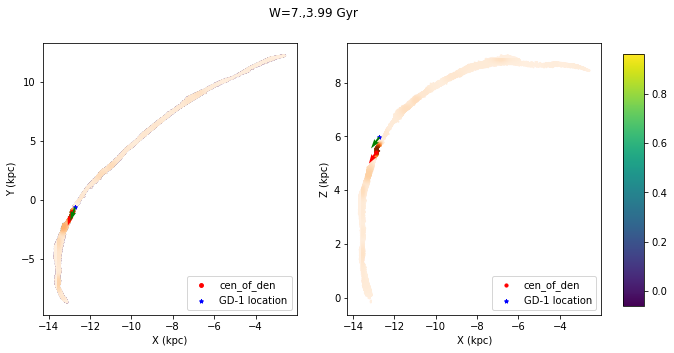

In [5]:
#compute surface density 

m1 = mm - mm_shift - 1
xcore,ycore,densxy,X_xy,Y_xy= compute_surface_density(x4[m1],y4[m1],method="hist")
_,zcore,densxz,X_xz,Z_xz = compute_surface_density(x4[m1],z4[m1],method="hist")

#find center of density using center of density technique
xc,yc,zc,vxc,vyc,vzc = find_centre_of_density(x4[m1],y4[m1],z4[m1],vx4[m1],vy4[m1],vz4[m1],m4[m1],nmax=5000,rmin=0.1)

print (xc,xcore)
print (yc,ycore)
print (zc,zcore)

theta = np.linspace(0,2*np.pi,1000)

f, axes = plt.subplots(nrows = 1, ncols = 2,figsize=(10,5))
f.suptitle("W=7.,{:.2f} Gyr".format(0.01*m1))

sc = axes[0].scatter(X_xy,Y_xy,c=densxy,s=1)
axes[0].scatter(X_xy,Y_xy,c=densxy,s=1,cmap="Oranges")
#axes[0].plot(xcore + r*np.cos(theta),ycore+r*np.sin(theta),color='r')
axes[0].scatter(xc,yc,c="r",s=15,label="cen_of_den")
#axes[0].scatter(X_xy[densxy.argmax()],Y_xy[densxy.argmax()],s=10,marker='o',c='b',label="max den")
axes[0].quiver(xc,yc,vxc,vyc,color="r",lw=5)
axes[0].scatter(gc1.x,gc1.y,c='blue',s=15,marker="*",label="GD-1 location")
axes[0].quiver(gc1.x.value,gc1.y.value,gc1.v_x.value,gc1.v_y.value,color="g",lw=5)
#axes[0].text(-15,-105,"core = ({:.2f},{:.2f})".format(xcore,ycore))
axes[0].legend(loc="lower right")
axes[0].set_xlabel('X (kpc)')
axes[0].set_ylabel('Y (kpc)')

#axes[1].plot(xcore + r*np.cos(theta),zcore+r*np.sin(theta),color='r')
axes[1].scatter(X_xz,Z_xz,c=densxz,s=1,cmap="Oranges")
axes[1].scatter(xc,zc,c="r",s=10,label="cen_of_den")
axes[1].quiver(xc,zc,0.1*vxc,0.1*vzc,color="r",lw=5)
axes[1].scatter(gc1.x,gc1.z,s=15,color="blue",marker="*",label="GD-1 location")
axes[1].quiver(gc1.x.value,gc1.z.value,0.1*gc1.v_x.value,0.1*gc1.v_z.value,color="g",lw=5)
#axes[1].scatter(X_xz[densxz.argmax()],Z_xz[densxz.argmax()],s=10,marker='o',c='b',label="max den")
#axes[1].text(-15,-105,"core = ({:.2f},{:.2f})".format(xcore_star_cdm,zcore_star_cdm))
axes[1].legend(loc="lower right")
axes[1].set_xlabel('X (kpc)')
axes[1].set_ylabel('Z (kpc)')
cbar_ax = f.add_axes([0.93, 0.15, 0.03, 0.7])

f.colorbar(sc,cax=cbar_ax)
#plt.tight_layout()
#plt.savefig('GD1_disk+1e5Halo_N16W5R20_4Gyr.pdf', bbox_inches = "tight")
plt.show()



track galactocentric radius 

In [6]:
rc = [];

tt=[];

for ii in range(400):
       
    xc,yc,zc,_,_,_ = find_centre_of_density(x4[ii],y4[ii],z4[ii],vx4[ii],vy4[ii],vz4[ii],m4[ii],nmax=5000,rmin=0.1)

    r = np.sqrt(xc**2 + yc**2 + zc**2)
    rc.append(r)
    tt.append(tt4[ii])
    

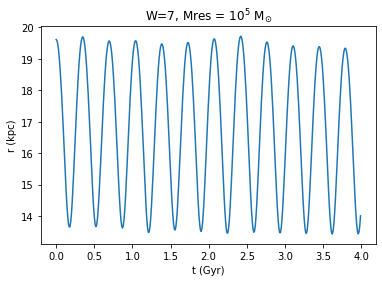

In [7]:
plt.figure()
plt.title(r"W=7, Mres = $10^{5}$ M$_{\odot}$")
plt.plot(tt,rc)
plt.ylabel("r (kpc)")
plt.xlabel("t (Gyr)")
#plt.savefig("Mres1e5_r_GC_N16W5R20.pdf")
plt.show()

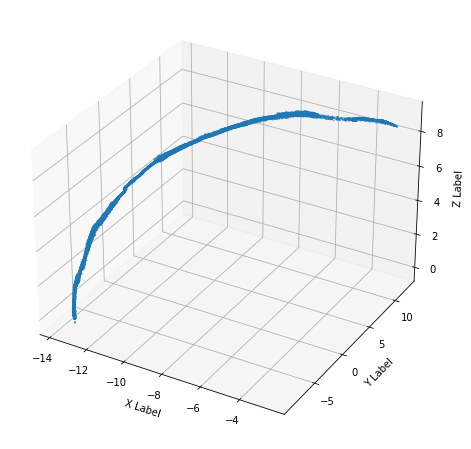

In [8]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x4[399], y4[399], z4[399],s=0.2)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

Align stream

[[ 5.55111512e-17 -2.77555756e-17  1.00000000e+00]]


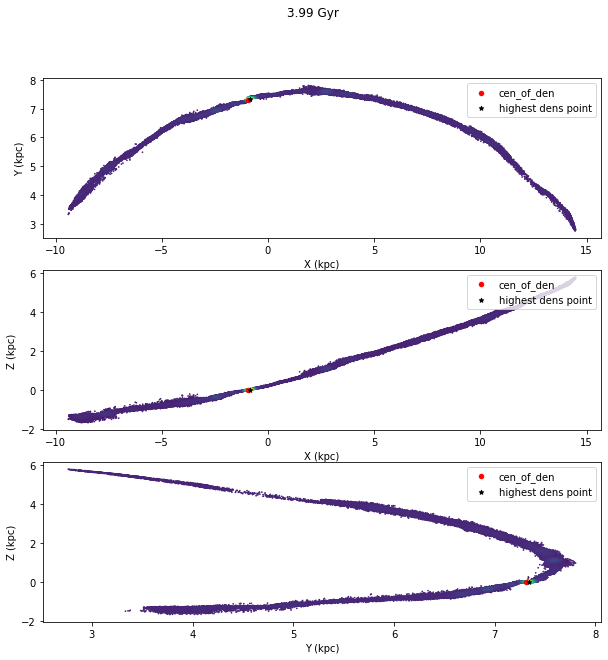

In [9]:
nn = 399
fn = dir1 + "snapshot_{:03d}.hdf5".format(nn) 
galc2,Lmean,xR,yR,zR,vxR,vyR,vzR = align_stream(fn,output_galcoords=True)

xc,yc,zc,_,_,_ = \
find_centre_of_density(xR,yR,zR,vxR,vyR,vzR,0.46*np.ones(len(galc2.x.value)),nmax=5000,rmin=0.1)

xcd,ycd,densxy,_x,_y= compute_surface_density(xR,yR,method="hist",bw=None,bins=[60,60])
x1cd,zcd,densxz,_x1,_z= compute_surface_density(xR,zR,method="hist",bw=None,bins=[60,60])
y1cd,z1cd,densyz,_y1,_z1= compute_surface_density(yR,zR,method="hist",bw=None,bins=[60,60])

plt.figure(figsize=(10,10))
plt.suptitle("{:.2f} Gyr".format(0.01*(nn)))
plt.subplot(3,1,1)
#plt.scatter(galc2.x.value,galc2.y.value,s=0.5,c=densxy)
plt.scatter(_x,_y,s=0.5,c=densxy)
plt.scatter(xc,yc,c='r',s=20,label="cen_of_den")
plt.scatter(xcd,ycd,c='k',s=20,marker="*",label="highest dens point")
#plt.scatter(_xc,_yc,c='b',s=10)
plt.legend(loc="upper right")
#plt.quiver(xcore,ycore,Lmean[0],Lmean[1])
plt.xlabel("X (kpc)")
plt.ylabel("Y (kpc)")
#plt.xlim(-6,6)
#plt.ylim(-6,6)

plt.subplot(3,1,2)
#plt.scatter(galc2.x.value,galc2.z.value,s=0.5,c=densxz)
plt.scatter(_x1,_z,s=0.5,c=densxz)
plt.scatter(xc,zc,c='r',s=20,label="cen_of_den")
#plt.scatter(_xc,_zc,c='b',s=10)
plt.scatter(x1cd,zcd,c='k',s=20,marker="*",label="highest dens point")
#plt.quiver(xcore,zcore,Lmean[0],Lmean[2])
plt.xlabel("X (kpc)")
plt.ylabel("Z (kpc)")
plt.legend(loc="upper right")
#plt.xlim(-6,6)
#plt.ylim(-36,6)

plt.subplot(3,1,3)
#plt.scatter(galc2.x.value,galc2.y.value,s=0.5,c=densxy)
plt.scatter(_y1,_z1,s=0.5,c=densxy)
plt.scatter(yc,zc,c='r',s=20,label="cen_of_den")
plt.scatter(y1cd,z1cd,c='k',s=20,marker="*",label="highest dens point")
#plt.scatter(_xc,_yc,c='b',s=10)
plt.legend(loc="upper right")
#plt.quiver(xcore,ycore,Lmean[0],Lmean[1])
plt.xlabel("Y (kpc)")
plt.ylabel("Z (kpc)")
#plt.savefig("surface_plots/plot_den_back_{}.png".format(nn))
plt.show()

Once the stream is rotated, it lies almost in z=0 plane, use the azimuthal angle as phi1 

In [10]:
phi1 = np.degrees(np.arctan2(yR,xR))
phi2 = np.degrees(np.arctan2(zR,np.sqrt(xR**2 + yR**2)))

p1core,p2core,densp12,p1,p2= compute_surface_density(phi1,phi2,method="hist",bw=0.01,bins=[60,60])

#bin in phi1 and compute velocity dispersion and density
phi1_bins = np.linspace(phi1.min(),phi1.max(),75)
phi1_mid = [0.5*(phi1_bins[ii]+phi1_bins[ii+1]) for ii in range(len(phi1_bins)-1)]
p1_binned = np.histogram(phi1,bins = phi1_bins)[0]

v_disp =[]
for ii in range(len(phi1_bins)-1):
    _vx = vxR[(phi1 > phi1_bins[ii]) & (phi1 < phi1_bins[ii+1])]
    _vy = vyR[(phi1 > phi1_bins[ii]) & (phi1 < phi1_bins[ii+1])]
    _vz = vzR[(phi1 > phi1_bins[ii]) & (phi1 < phi1_bins[ii+1])]
    v_disp.append(np.sqrt(np.std(_vx)**2 + np.std(_vy)**2 + np.std(_vz)**2))

#print (v_disp)
#print (phi1_bins)

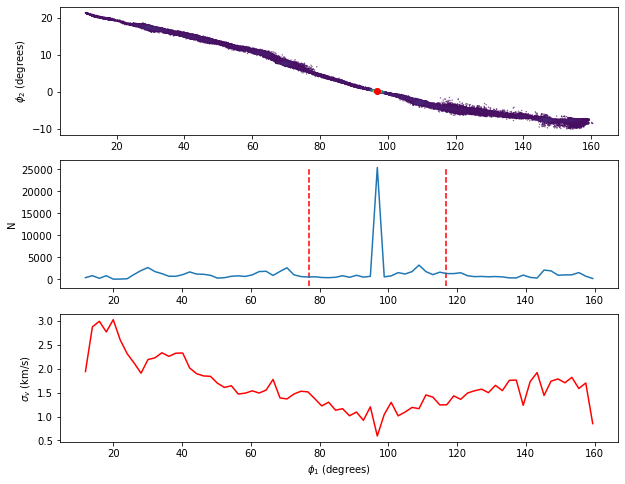

In [11]:
plt.figure(figsize=(10,8))
plt.subplot(3,1,1)
plt.scatter(p1,p2,s=0.1,c=densp12)
plt.scatter(p1core,p2core,color="r")
#plt.xlabel(r"$\phi_{1}$ (degrees)")
plt.ylabel(r"$\phi_{2}$ (degrees)")

plt.subplot(3,1,2)
plt.plot(phi1_mid,p1_binned)
plt.vlines(p1core + 20, -1500,p1_binned.max(),color="r",ls="--")
plt.vlines(p1core - 20, -1500,p1_binned.max(),color="r",ls="--")
#plt.xlabel(r"$\phi_{1}$ (degrees)")
plt.ylim(-2000,27000)
plt.ylabel("N")

plt.subplot(3,1,3)
plt.plot(phi1_mid,v_disp,c='r')
plt.xlabel(r"$\phi_{1}$ (degrees)")
plt.ylabel(r"$\sigma_v$ (km/s)")
plt.show()

In [12]:
#The stream is moving to the right.
#Select leading and trailing arm after excluding 10 deg around the progenitor
#The cuts at the end of the stream were chosen after examining the density

p1_lead = phi1[(phi1 > p1core + 20) & (phi1 < 159.)]
p1_trail = phi1[(phi1 < p1core - 20) & (phi1 > 35.)]

#print (np.histogram(p1_lead,bins=90))

p1_bin_lead_mid,Ndn_lead,Ndn_lead_err,nden_lead,nden_lead_err,pp_lead = compute_ndenp1(p1_lead,Nbins=86,polydeg=3)
p1_bin_trail_mid,Ndn_trail,Ndn_trail_err,nden_trail,nden_trail_err,pp_trail = compute_ndenp1(p1_trail,Nbins=84,polydeg=3)

bin width = 0.50
19855
bin width = 0.50
22811


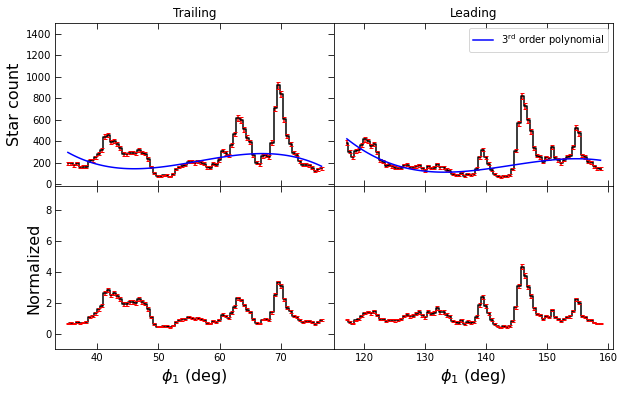

In [13]:
plt.figure(figsize=(10,6))

ax1=plt.subplot(2,2,1)
ax1.set_title("Trailing")
ax1.tick_params(axis='both',direction='in',which='both',top=True,right=True,length=6.,labelbottom=False) 
plt.plot(p1_bin_trail_mid,Ndn_trail,c='k',ds='steps-mid')
plt.errorbar(p1_bin_trail_mid,Ndn_trail,Ndn_trail_err,marker='None',ls='None',capsize=2.,ecolor='r')
#plt.text(0.42,0.85,'Perturbed',fontsize=15,transform=ax2.transAxes)
plt.plot(p1_bin_trail_mid,pp_trail,c='b',label=r'$3^{\rm{rd}}$ order polynomial')
plt.ylim(-20,1500)
plt.xlabel([])
#plt.ylabel([])
#plt.yticks([])
plt.ylabel('Star count',fontsize=16)
#plt.legend(loc='upper right',fontsize=10)


ax2=plt.subplot(2,2,2)
ax2.tick_params(axis='both',direction='in',which='both',top=True,right=True,length=6.,labelbottom=False) 
ax2.set_title("Leading")
plt.plot(p1_bin_lead_mid,Ndn_lead,c='k',ds='steps-mid')
plt.errorbar(p1_bin_lead_mid,Ndn_lead,Ndn_lead_err,marker='None',ls='None',capsize=2.,ecolor='r')
#plt.text(0.42,0.85,'Perturbed',fontsize=15,transform=ax2.transAxes)
plt.plot(p1_bin_lead_mid,pp_lead,c='b',label=r'$3^{\rm{rd}}$ order polynomial')
plt.ylim(-20,1500)
plt.xlabel([])
plt.yticks([])
#plt.ylabel('Star count',fontsize=16)
plt.legend(loc='upper right',fontsize=10)

ax3=plt.subplot(2,2,3)
ax3.tick_params(axis='both',direction='in',which='both',top=True,right=True,left=True,length=6.) 
plt.plot(p1_bin_trail_mid,nden_trail,ds='steps-mid',c='k')
#plt.text(0.28,0.85,r'Divided by $3^{\rm{rd}}$ order polynomial',fontsize=15,transform=ax3.transAxes)
plt.errorbar(p1_bin_trail_mid,nden_trail,nden_trail_err,marker='None',capsize=2.,ls='None',ecolor='r')
plt.ylim(-1,9.5)
#plt.xlim(0.2,15.)
#plt.yticks([])
plt.xlabel(r'$\phi_{1}$ (deg)',fontsize=16)
plt.ylabel('Normalized',fontsize=16)
plt.subplots_adjust(wspace=0, hspace=0)


ax4=plt.subplot(2,2,4)
ax4.tick_params(axis='both',direction='in',which='both',top=True,right=True,length=6.) 
plt.plot(p1_bin_lead_mid,nden_lead,ds='steps-mid',c='k')
#plt.text(0.28,0.85,r'Divided by $3^{\rm{rd}}$ order polynomial',fontsize=15,transform=ax3.transAxes)
plt.errorbar(p1_bin_lead_mid,nden_lead,nden_lead_err,marker='None',capsize=2.,ls='None',ecolor='r')
plt.ylim(-1,9.5)
#plt.xlim(0.2,15.)
plt.yticks([])
plt.xlabel(r'$\phi_{1}$ (deg)',fontsize=16)
#plt.ylabel('Normalized',fontsize=16)
plt.subplots_adjust(wspace=0, hspace=0)


#plt.savefig('plots/nden_1010Msun_streamdf_patspeed39.pdf')
plt.show()

In [14]:
px_lead, py_lead, py_lead_err = compute_Pk(p1_bin_lead_mid,nden_lead,nden_lead_err, scaling = 'spectrum')
px_trail, py_trail, py_trail_err = compute_Pk(p1_bin_trail_mid,nden_trail,nden_trail_err, scaling = 'spectrum')

/scratch/user/banik/.conda/envs/galpy1.7/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide



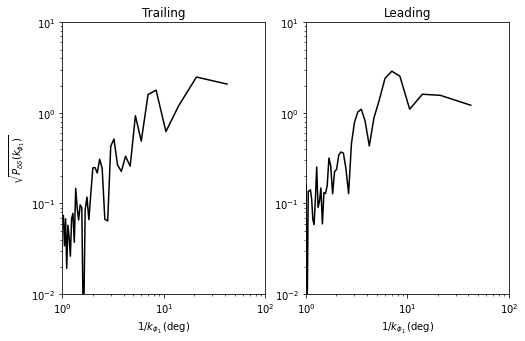

In [15]:
plt.figure(figsize=(8,5))

ax1=plt.subplot(1,2,1)
ax1.set_title("Trailing")
plt.loglog(px_trail, py_trail,color='k')
#loglog(px0,pyerr0,color='g',ls='--',zorder=1)
plt.ylabel(r'$\sqrt{P_{\delta\delta}(k_{\phi_{1}})}$',size=10)
plt.xlabel(r'$1/k_{\phi_{1}}\,(\mathrm{deg})$',size=10)
plt.ylim(0.01,10.)
plt.xlim(1,100.)


ax2=plt.subplot(1,2,2)
ax2.set_title("Leading")
plt.loglog(px_lead, py_lead,color='k')
plt.xlabel(r'$1/k_{\phi_{1}}\,(\mathrm{deg})$',size=10)
plt.ylim(0.01,10.)
plt.xlim(1,100.)

#plt.legend(loc='lower right')
plt.show()

#savefig('plots/power_1mil39_patspeed_streamdf_5Gyrbarpot.pdf')

We want to test whether impacts from subhalos of mass $10^5$ Msun alone can result in density power similar to the one obtained in the $10^5$ Msun resolution live N-body simulations. To test this we :

1. Ran streampepperdf simulations of the mock GD-1 stream using 10 times (timescdm) the number of subhalos in the mass bin $10^{4.5} - 10^{5.5}$ Msun and assigned all of them a fixed mass of $10^5$ Msun and a Plummer scale radius of 0.2/2.8 kpc.
2. Compute number density of halo particles within 17 kpc from the live halo snapshot (nden_part)
3. Compute number density of subhalos of mass $10^5$ Msun within 17 kpc, using number density of subhalos in the mass range $10^{4.5} - 10^{5.5}$ Msun using the SHMF, (nden_subhalo)
4. compute the power spectrum from step 1 and scale it by sqrt(nden_part/nden_subhalo/timescdm)

Compute number density of halo particles within 17 kpc

In [16]:
dir1 = "../Gizmo/ics/GD1_inMcMillanHaloVelFlipped_Mres1e5_Disk_N100W7R20_forward_integrate/"

mm = 1
mm_shift = 0

tt,id1,x1,y1,z1,vx1,vy1,vz1,m1 = extract_data_of_ptype(folder=dir1,ptype=1,nfiles=mm,shift_file_ind=mm_shift,shift_ID=0,pot_acc=False)

r1 = np.sqrt(x1[0]**2 +y1[0]**2 +z1[0]**2)
nden_part = len(r1[r1 <= 17.])/((4/3)*np.pi*(17./8)**3) #in galpy units
print (nden_part)


31667.829436694523


Compute number of subhalos of mass $10^5$ Msun within 17 kpc \
by computing the number of subhalos in the mass range $10^{4.5} - 10^{5.5}$ Msun using the SHMF

In [17]:
from scipy.interpolate import UnivariateSpline
from scipy import integrate, interpolate, signal

def Einasto(r):
    al=0.678 #alpha_shape
    rm2=199 #kpc, see Erkal et al 1606.04946 for scaling to M^1/3
    return np.exp((-2./al)*((r/rm2)**al -1.))*4*np.pi*(r**2)

def dndM_cdm(M,c0kpc=2.02*10**(-13),mf_slope=-1.9):
    #c0kpc=2.02*10**(-13) #Msun^-1 kpc^-3 from Denis' paper
    m0=2.52*10**7 #Msun from Denis' paper
    return c0kpc*((M/m0)**mf_slope)

def nsub_cdm(M1,M2,r=20.,c0kpc=2.02*10**(-13),mf_slope=-1.9):
    #number density of subhalos in kpc^-3
    m1=10**(M1)
    m2=10**(M2)
    return integrate.quad(dndM_cdm,m1,m2,args=(c0kpc,mf_slope))[0]*integrate.quad(Einasto,0.,r)[0]*(8.**3.)/(4*np.pi*(r**3)/3) #in Galpy units

nden_subhalo = nsub_cdm(4.5,5.5,r=17.)

print (nden_subhalo)

print (nden_part/nden_subhalo)

12.595631399838883
2514.1915027062164


/scratch/user/banik/.conda/envs/galpy1.7/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide

/scratch/user/banik/.conda/envs/galpy1.7/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in true_divide



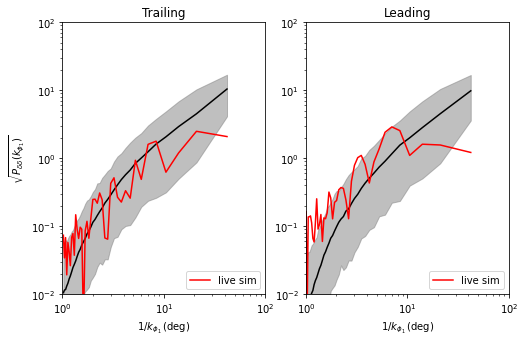

In [18]:
timescdm = 10
scale_factor = np.sqrt(nden_part/nden_subhalo/timescdm)


N=1000 #no of sims 
fn_trail = "dens_Omega/dens_contrast_trailing_mockgd1stream_{}XCDMsubhalo1e5Msun_physical_coords_Nbodybins.dat".format(timescdm)
fn_lead = "dens_Omega/dens_contrast_leading_mockgd1stream_{}XCDMsubhalo1e5Msun_physical_coords_Nbodybins.dat".format(timescdm) 

px_lead_sub, py_lead_sub= compute_pk_scatter(fname=fn_lead,N=N,scatter=False)
plotx_l, dum, low_l, high_l= compute_pk_scatter(fn_lead,N=N,scatter=True) 

px_trail_sub, py_trail_sub= compute_pk_scatter(fname=fn_trail,N=N,scatter=False)
plotx_t, dum, low_t, high_t= compute_pk_scatter(fn_trail,N=N,scatter=True) 



plt.figure(figsize=(8,5))

ax1=plt.subplot(1,2,1)
ax1.set_title("Trailing")
plt.loglog(px_trail_sub, py_trail_sub*scale_factor,color='k')
plt.loglog(px_trail, py_trail,color='r',label="live sim")
plt.fill_between(plotx_t,low_t*scale_factor,high_t*scale_factor,color='gray',alpha=0.5)
#loglog(px0,pyerr0,color='g',ls='--',zorder=1)
plt.ylabel(r'$\sqrt{P_{\delta\delta}(k_{\phi_{1}})}$',size=10)
plt.xlabel(r'$1/k_{\phi_{1}}\,(\mathrm{deg})$',size=10)
plt.legend(loc="lower right")
plt.ylim(0.01,100.)
plt.xlim(1,100.)


ax2=plt.subplot(1,2,2)
ax2.set_title("Leading")
plt.loglog(px_lead_sub, py_lead_sub*scale_factor,color='k')
plt.loglog(px_lead, py_lead,color='r',label="live sim")
plt.fill_between(plotx_l,low_l*scale_factor,high_l*scale_factor,color='gray',alpha=0.5)
plt.xlabel(r'$1/k_{\phi_{1}}\,(\mathrm{deg})$',size=10)
plt.legend(loc="lower right")
plt.ylim(0.01,100.)
plt.xlim(1,100.)

#plt.legend(loc='lower right')
plt.show()

### Analyze the $10^{4} \ \rm{M}_{\odot}$ resolution case
Halo particle softening = 0.02 kpc \
cluster particle softening = 2 pc \
Analytic disk from MWPotential2014 used.

In [16]:
dir1 = "../Gizmo/ics/GD1_inMcMillanHaloVelFlipped_Mres1e4_Disk_N100W7R20_forward_integrate_from3p9Gyr/"
file_ID_shift = 390
mm = 13 #401# - file_ID_shift only the final snap loaded since these are huge
mm_shift = 0

tt4,id4,x4,y4,z4,vx4,vy4,vz4,m4 = extract_data_of_ptype(folder=dir1,ptype=4,nfiles=mm,shift_file_ind=mm-1,shift_ID=0,pot_acc=False)

In [17]:
o= Orbit.from_name("GD1")

c1 = coord.ICRS(ra=o.ra()*u.degree, dec=o.dec()*u.degree,
                distance=o.dist()*u.kpc,
                pm_ra_cosdec=o.pmra()*u.mas/u.yr,
                pm_dec=o.pmdec()*u.mas/u.yr,
                radial_velocity=o.vlos()*u.km/u.s)

gc1 = c1.transform_to(coord.Galactocentric)

print(gc1.x,gc1.y,gc1.z,gc1.v_x,gc1.v_y,gc1.v_z)

-12.726089322382306 kpc -0.6519411336112344 kpc 5.975650034386612 kpc -73.32820069333705 km / s -210.86651691960355 km / s -100.0530450447977 km / s


plot stream

-12.993437956227808 -12.925742
-1.4383636097663839 -1.1695075
5.5692514042020775 5.4880834


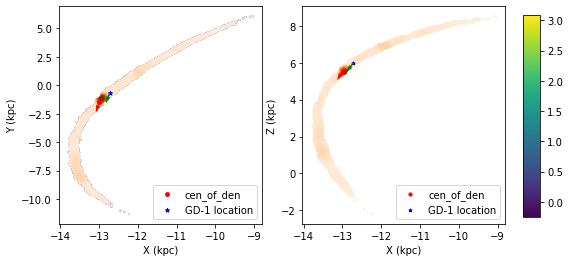

In [18]:
#compute surface density 

m1 = 0
xcore,ycore,densxy,X_xy,Y_xy= compute_surface_density(x4[m1],y4[m1],method="hist")
_,zcore,densxz,X_xz,Z_xz = compute_surface_density(x4[m1],z4[m1],method="hist")

#find center of density using center of density technique
xc,yc,zc,vxc,vyc,vzc = find_centre_of_density(x4[m1],y4[m1],z4[m1],vx4[m1],vy4[m1],vz4[m1],m4[m1],nmax=5000,rmin=0.1)

print (xc,xcore)
print (yc,ycore)
print (zc,zcore)

theta = np.linspace(0,2*np.pi,1000)

f, axes = plt.subplots(nrows = 1, ncols = 2,figsize=(8,4))
#f.suptitle("W=7.,{:.2f} Gyr".format(0.01*mn))

sc = axes[0].scatter(X_xy,Y_xy,c=densxy,s=1)
axes[0].scatter(X_xy,Y_xy,c=densxy,s=1,cmap="Oranges")
#axes[0].plot(xcore + r*np.cos(theta),ycore+r*np.sin(theta),color='r')
axes[0].scatter(xc,yc,c="r",s=15,label="cen_of_den")
#axes[0].scatter(X_xy[densxy.argmax()],Y_xy[densxy.argmax()],s=10,marker='o',c='b',label="max den")
axes[0].quiver(xc,yc,vxc,vyc,color="r",lw=5)
axes[0].scatter(gc1.x,gc1.y,c='blue',s=15,marker="*", label="GD-1 location")
axes[0].quiver(gc1.x.value,gc1.y.value,gc1.v_x.value,gc1.v_y.value,color="g",lw=5)
#axes[0].text(-15,-105,"core = ({:.2f},{:.2f})".format(xcore,ycore))
axes[0].legend(loc="lower right")
axes[0].set_xlabel('X (kpc)')
axes[0].set_ylabel('Y (kpc)')

#axes[1].plot(xcore + r*np.cos(theta),zcore+r*np.sin(theta),color='r')
axes[1].scatter(X_xz,Z_xz,c=densxz,s=1,cmap="Oranges")
axes[1].scatter(xc,zc,c="r",s=10,label="cen_of_den")
axes[1].quiver(xc,zc,0.1*vxc,0.1*vzc,color="r",lw=5)
axes[1].scatter(gc1.x,gc1.z,s=10,c="b",marker="*", label="GD-1 location")
axes[1].quiver(gc1.x.value,gc1.z.value,0.1*gc1.v_x.value,0.1*gc1.v_z.value,color="g",lw=5)
#axes[1].scatter(X_xz[densxz.argmax()],Z_xz[densxz.argmax()],s=10,marker='o',c='b',label="max den")
#axes[1].text(-15,-105,"core = ({:.2f},{:.2f})".format(xcore_star_cdm,zcore_star_cdm))
axes[1].legend(loc="lower right")
axes[1].set_xlabel('X (kpc)')
axes[1].set_ylabel('Z (kpc)')
cbar_ax = f.add_axes([0.93, 0.15, 0.03, 0.7])

f.colorbar(sc,cax=cbar_ax)
#plt.tight_layout()
#plt.savefig('GD1_disk+1e5Halo_N16W5R20_4Gyr.pdf', bbox_inches = "tight")
plt.show()



Align stream

[[-2.77555756e-17 -2.77555756e-17  1.00000000e+00]]


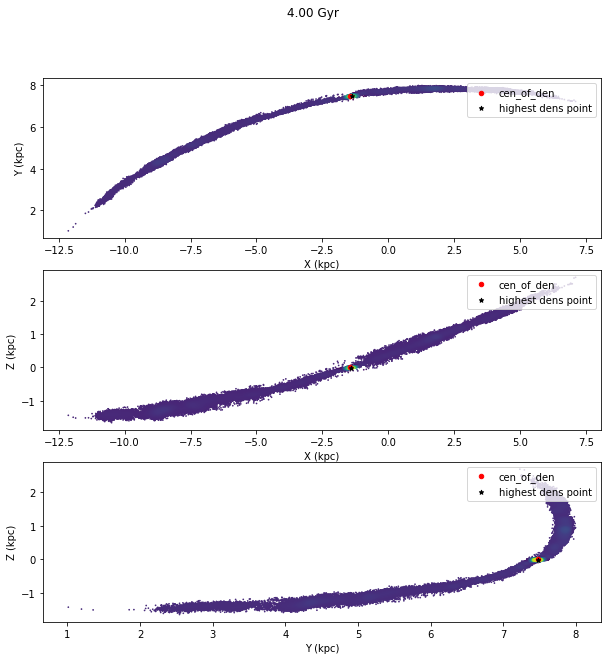

In [19]:
nn = 12
fn = dir1 + "snapshot_{:03d}.hdf5".format(nn) 
galc2,Lmean,xR,yR,zR,vxR,vyR,vzR = align_stream(fn,output_galcoords=True)

xc,yc,zc,_,_,_ = \
find_centre_of_density(xR,yR,zR,vxR,vyR,vzR,0.46*np.ones(len(galc2.x.value)),nmax=5000,rmin=0.1)

xcd,ycd,densxy,_x,_y= compute_surface_density(xR,yR,method="hist",bw=None,bins=[60,60])
x1cd,zcd,densxz,_x1,_z= compute_surface_density(xR,zR,method="hist",bw=None,bins=[60,60])
y1cd,z1cd,densyz,_y1,_z1= compute_surface_density(yR,zR,method="hist",bw=None,bins=[60,60])

plt.figure(figsize=(10,10))
plt.suptitle("{:.2f} Gyr".format(4.0))
plt.subplot(3,1,1)
#plt.scatter(galc2.x.value,galc2.y.value,s=0.5,c=densxy)
plt.scatter(_x,_y,s=0.5,c=densxy)
plt.scatter(xc,yc,c='r',s=20,label="cen_of_den")
plt.scatter(xcd,ycd,c='k',s=20,marker="*",label="highest dens point")
#plt.scatter(_xc,_yc,c='b',s=10)
plt.legend(loc="upper right")
#plt.quiver(xcore,ycore,Lmean[0],Lmean[1])
plt.xlabel("X (kpc)")
plt.ylabel("Y (kpc)")
#plt.xlim(-6,6)
#plt.ylim(-6,6)

plt.subplot(3,1,2)
#plt.scatter(galc2.x.value,galc2.z.value,s=0.5,c=densxz)
plt.scatter(_x1,_z,s=0.5,c=densxz)
plt.scatter(xc,zc,c='r',s=20,label="cen_of_den")
#plt.scatter(_xc,_zc,c='b',s=10)
plt.scatter(x1cd,zcd,c='k',s=20,marker="*",label="highest dens point")
#plt.quiver(xcore,zcore,Lmean[0],Lmean[2])
plt.xlabel("X (kpc)")
plt.ylabel("Z (kpc)")
plt.legend(loc="upper right")
#plt.xlim(-6,6)
#plt.ylim(-36,6)

plt.subplot(3,1,3)
#plt.scatter(galc2.x.value,galc2.y.value,s=0.5,c=densxy)
plt.scatter(_y1,_z1,s=0.5,c=densxy)
plt.scatter(yc,zc,c='r',s=20,label="cen_of_den")
plt.scatter(y1cd,z1cd,c='k',s=20,marker="*",label="highest dens point")
#plt.scatter(_xc,_yc,c='b',s=10)
plt.legend(loc="upper right")
#plt.quiver(xcore,ycore,Lmean[0],Lmean[1])
plt.xlabel("Y (kpc)")
plt.ylabel("Z (kpc)")
#plt.savefig("surface_plots/plot_den_back_{}.png".format(nn))
plt.show()

In [20]:
#Once the stream is rotated, it lies almost in z=0 plane, use the azimuthal angle as phi1 
phi1 = np.degrees(np.arctan2(yR,xR))
phi2 = np.degrees(np.arctan2(zR,np.sqrt(xR**2 + yR**2)))

p1core,p2core,densp12,p1,p2= compute_surface_density(phi1,phi2,method="hist",bw=0.01,bins=[60,60])

#bin in phi1 and compute velocity dispersion and density
phi1_bins = np.linspace(phi1.min(),phi1.max(),75)
phi1_mid = [0.5*(phi1_bins[ii]+phi1_bins[ii+1]) for ii in range(len(phi1_bins)-1)]
p1_binned = np.histogram(phi1,bins = phi1_bins)[0]

v_disp =[]
for ii in range(len(phi1_bins)-1):
    _vx = vxR[(phi1 > phi1_bins[ii]) & (phi1 < phi1_bins[ii+1])]
    _vy = vyR[(phi1 > phi1_bins[ii]) & (phi1 < phi1_bins[ii+1])]
    _vz = vzR[(phi1 > phi1_bins[ii]) & (phi1 < phi1_bins[ii+1])]
    v_disp.append(np.sqrt(np.std(_vx)**2 + np.std(_vy)**2 + np.std(_vz)**2))

#print (v_disp)
#print (phi1_bins)

/scratch/user/banik/.conda/envs/galpy1.7/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)

/scratch/user/banik/.conda/envs/galpy1.7/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)

/scratch/user/banik/.conda/envs/galpy1.7/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



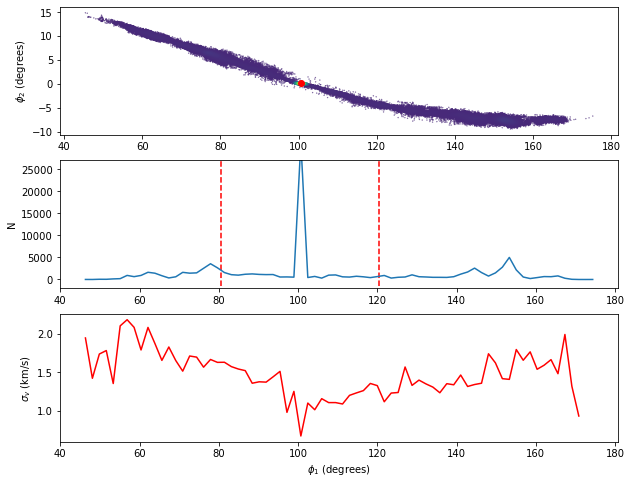

In [21]:
plt.figure(figsize=(10,8))
plt.subplot(3,1,1)
plt.scatter(p1,p2,s=0.1,c=densp12)
plt.scatter(p1core,p2core,color="r")
#plt.xlabel(r"$\phi_{1}$ (degrees)")
plt.ylabel(r"$\phi_{2}$ (degrees)")

plt.subplot(3,1,2)
plt.plot(phi1_mid,p1_binned)
plt.vlines(p1core + 20, -1500,p1_binned.max(),color="r",ls="--")
plt.vlines(p1core - 20, -1500,p1_binned.max(),color="r",ls="--")
#plt.xlabel(r"$\phi_{1}$ (degrees)")
plt.ylim(-2000,27000)
plt.ylabel("N")

plt.subplot(3,1,3)
plt.plot(phi1_mid,v_disp,c='r')
plt.xlabel(r"$\phi_{1}$ (degrees)")
plt.ylabel(r"$\sigma_v$ (km/s)")
plt.show()

In [22]:
#The stream is moving to the right.
#Select leading and trailing arm after excluding 10 deg around the progenitor

p1_lead = phi1[(phi1 > p1core + 20) & (phi1 < 170.)]
p1_trail = phi1[(phi1 < p1core - 20) & (phi1 > 52.)]

#print (np.histogram(p1_lead,bins=95))

p1_bin_lead_mid,Ndn_lead,Ndn_lead_err,nden_lead,nden_lead_err,pp_lead = compute_ndenp1(p1_lead,Nbins=99,polydeg=3)
p1_bin_trail_mid,Ndn_trail,Ndn_trail_err,nden_trail,nden_trail_err,pp_trail = compute_ndenp1(p1_trail,Nbins=58,polydeg=3)

bin width = 0.50
29719
bin width = 0.50
21019


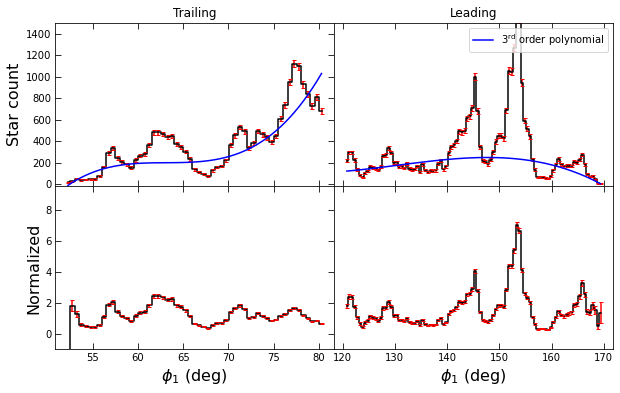

In [23]:
plt.figure(figsize=(10,6))

ax1=plt.subplot(2,2,1)
ax1.set_title("Trailing")
ax1.tick_params(axis='both',direction='in',which='both',top=True,right=True,length=6.,labelbottom=False) 
plt.plot(p1_bin_trail_mid,Ndn_trail,c='k',ds='steps-mid')
plt.errorbar(p1_bin_trail_mid,Ndn_trail,Ndn_trail_err,marker='None',ls='None',capsize=2.,ecolor='r')
#plt.text(0.42,0.85,'Perturbed',fontsize=15,transform=ax2.transAxes)
plt.plot(p1_bin_trail_mid,pp_trail,c='b',label=r'$3^{\rm{rd}}$ order polynomial')
plt.ylim(-20,1500)
plt.xlabel([])
#plt.ylabel([])
#plt.yticks([])
plt.ylabel('Star count',fontsize=16)
#plt.legend(loc='upper right',fontsize=10)


ax2=plt.subplot(2,2,2)
ax2.tick_params(axis='both',direction='in',which='both',top=True,right=True,length=6.,labelbottom=False) 
ax2.set_title("Leading")
plt.plot(p1_bin_lead_mid,Ndn_lead,c='k',ds='steps-mid')
plt.errorbar(p1_bin_lead_mid,Ndn_lead,Ndn_lead_err,marker='None',ls='None',capsize=2.,ecolor='r')
#plt.text(0.42,0.85,'Perturbed',fontsize=15,transform=ax2.transAxes)
plt.plot(p1_bin_lead_mid,pp_lead,c='b',label=r'$3^{\rm{rd}}$ order polynomial')
plt.ylim(-20,1500)
plt.xlabel([])
plt.yticks([])
#plt.ylabel('Star count',fontsize=16)
plt.legend(loc='upper right',fontsize=10)

ax3=plt.subplot(2,2,3)
ax3.tick_params(axis='both',direction='in',which='both',top=True,right=True,left=True,length=6.) 
plt.plot(p1_bin_trail_mid,nden_trail,ds='steps-mid',c='k')
#plt.text(0.28,0.85,r'Divided by $3^{\rm{rd}}$ order polynomial',fontsize=15,transform=ax3.transAxes)
plt.errorbar(p1_bin_trail_mid,nden_trail,nden_trail_err,marker='None',capsize=2.,ls='None',ecolor='r')
plt.ylim(-1,9.5)
#plt.xlim(0.2,15.)
#plt.yticks([])
plt.xlabel(r'$\phi_{1}$ (deg)',fontsize=16)
plt.ylabel('Normalized',fontsize=16)
plt.subplots_adjust(wspace=0, hspace=0)


ax4=plt.subplot(2,2,4)
ax4.tick_params(axis='both',direction='in',which='both',top=True,right=True,length=6.) 
plt.plot(p1_bin_lead_mid,nden_lead,ds='steps-mid',c='k')
#plt.text(0.28,0.85,r'Divided by $3^{\rm{rd}}$ order polynomial',fontsize=15,transform=ax3.transAxes)
plt.errorbar(p1_bin_lead_mid,nden_lead,nden_lead_err,marker='None',capsize=2.,ls='None',ecolor='r')
plt.ylim(-1,9.5)
#plt.xlim(0.2,15.)
plt.yticks([])
plt.xlabel(r'$\phi_{1}$ (deg)',fontsize=16)
#plt.ylabel('Normalized',fontsize=16)
plt.subplots_adjust(wspace=0, hspace=0)


#plt.savefig('plots/nden_1010Msun_streamdf_patspeed39.pdf')
plt.show()

In [24]:
px_lead, py_lead, py_lead_err = compute_Pk(p1_bin_lead_mid,nden_lead,nden_lead_err, scaling = 'spectrum')
px_trail, py_trail, py_trail_err = compute_Pk(p1_bin_trail_mid,nden_trail,nden_trail_err, scaling = 'spectrum')

/scratch/user/banik/.conda/envs/galpy1.7/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide



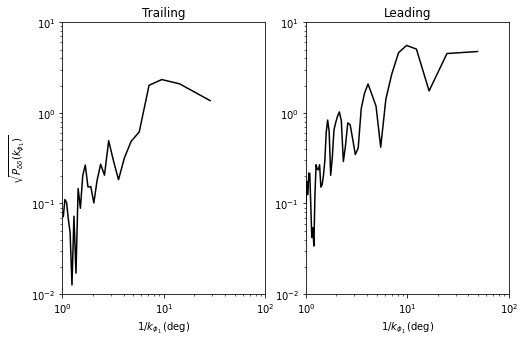

In [25]:
plt.figure(figsize=(8,5))

ax1=plt.subplot(1,2,1)
ax1.set_title("Trailing")
plt.loglog(px_trail, py_trail,color='k')
#loglog(px0,pyerr0,color='g',ls='--',zorder=1)
plt.ylabel(r'$\sqrt{P_{\delta\delta}(k_{\phi_{1}})}$',size=10)
plt.xlabel(r'$1/k_{\phi_{1}}\,(\mathrm{deg})$',size=10)
plt.ylim(0.01,10.)
plt.xlim(1,100.)


ax2=plt.subplot(1,2,2)
ax2.set_title("Leading")
plt.loglog(px_lead, py_lead,color='k')
plt.xlabel(r'$1/k_{\phi_{1}}\,(\mathrm{deg})$',size=10)
plt.ylim(0.01,10.)
plt.xlim(1,100.)

#plt.legend(loc='lower right')
plt.show()

#savefig('plots/power_1mil39_patspeed_streamdf_5Gyrbarpot.pdf')

## Print $r$ and $\frac{M(<r)}{r^{2}}$ , which will be used in Gizmo to interpolate the halo potential


In [ ]:
def compute_mass_within_r(r,ptype=1,dir=dir1,snap=0):
    _,_,x1,y1,z1,_,_,_,m1 = extract_data_of_ptype(folder=dir,ptype=ptype,nfiles=snap,shift_file_ind=snap-1,shift_ID=0,pot_acc=False)
    _r = np.sqrt(x1[0]**2 + y1[0]**2 + z1[0]**2)
    return np.sum(m1[0][_r < r])
    

#radial grid 
rr = np.linspace(1,50,80)
#r_mid = np.array([0.5*(r_bin_edge[ii] + r_bin_edge[ii+1]) for ii in range(len(r_bin_edge)-)])

m_within = np.array([compute_mass_within_r(ii,ptype=1,dir=dir1,snap=mm) for ii in rr]) 

#G=43007.1
#rad_acc = G*m_within/rr**2

print (list(rr))
#print (m_within)
print (list(m_within/(rr**2)))

## Interpolated halo potential Mres = $10^{5}$ $M_{\odot}$ + analytic disk

In [26]:
dir1 = "../Gizmo/ics/GD1_InterpMcMillanHalo1e5Msun_AnalyticDisk_N100W7R20_forward_integrate/"

mm = 401 #401# - file_ID_shift
mm_shift = 0

tt4,id4,x4,y4,z4,vx4,vy4,vz4,m4 = extract_data_of_ptype(folder=dir1,ptype=4,nfiles=mm,shift_file_ind=0,shift_ID=0,pot_acc=False)

In [27]:
o= Orbit.from_name("GD1")

c1 = coord.ICRS(ra=o.ra()*u.degree, dec=o.dec()*u.degree,
                distance=o.dist()*u.kpc,
                pm_ra_cosdec=o.pmra()*u.mas/u.yr,
                pm_dec=o.pmdec()*u.mas/u.yr,
                radial_velocity=o.vlos()*u.km/u.s)

gc1 = c1.transform_to(coord.Galactocentric)

print(gc1.x,gc1.y,gc1.z,gc1.v_x,gc1.v_y,gc1.v_z)

-12.726089322382306 kpc -0.6519411336112344 kpc 5.975650034386612 kpc -73.32820069333705 km / s -210.86651691960355 km / s -100.0530450447977 km / s


In [28]:
rc_Interp = [];

tt_Interp=[];

for ii in range(400):
       
    xc,yc,zc,_,_,_ = find_centre_of_density(x4[ii],y4[ii],z4[ii],vx4[ii],vy4[ii],vz4[ii],m4[ii],nmax=5000,rmin=0.1)

    r = np.sqrt(xc**2 + yc**2 + zc**2)
    rc_Interp.append(r)
    tt_Interp.append(tt4[ii])
    

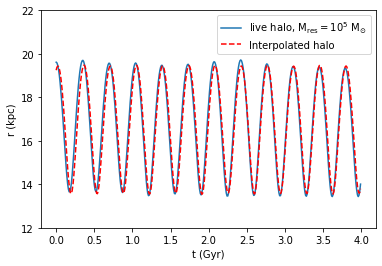

In [30]:
plt.figure()
#plt.title(r"W=7, Mres = $10^{5}$ M$_{\odot}$")
plt.plot(tt,rc, label=r"live halo, M$_{\rm{res}} = 10^{5}$ M$_{\odot}$")
plt.plot(tt_Interp,rc_Interp,c="r",label="Interpolated halo",ls="--")
plt.ylabel("r (kpc)")
plt.xlabel("t (Gyr)")
plt.ylim(12,22)
plt.legend(loc="upper right")
#plt.savefig("Mres1e5_r_GC_N16W5R20.pdf")
plt.show()

plot stream

-12.745510608010692 -12.70056562306716
-0.7071696723842102 -0.8175619573192917
5.947191015069718 6.018010204055318


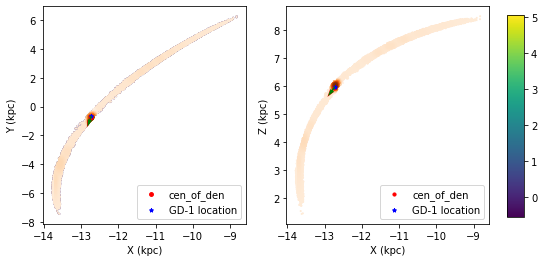

In [31]:
#compute surface density 

m1 = 400
xcore,ycore,densxy,X_xy,Y_xy= compute_surface_density(x4[m1],y4[m1],method="hist")
_,zcore,densxz,X_xz,Z_xz = compute_surface_density(x4[m1],z4[m1],method="hist")

#find center of density using center of density technique
xc,yc,zc,vxc,vyc,vzc = find_centre_of_density(x4[m1],y4[m1],z4[m1],vx4[m1],vy4[m1],vz4[m1],m4[m1],nmax=5000,rmin=0.1)

print (xc,xcore)
print (yc,ycore)
print (zc,zcore)

theta = np.linspace(0,2*np.pi,1000)

f, axes = plt.subplots(nrows = 1, ncols = 2,figsize=(8,4))
#f.suptitle("W=7.,{:.2f} Gyr".format(0.01*mn))

sc = axes[0].scatter(X_xy,Y_xy,c=densxy,s=1)
axes[0].scatter(X_xy,Y_xy,c=densxy,s=1,cmap="Oranges")
#axes[0].plot(xcore + r*np.cos(theta),ycore+r*np.sin(theta),color='r')
axes[0].scatter(xc,yc,c="r",s=15,label="cen_of_den")
#axes[0].scatter(X_xy[densxy.argmax()],Y_xy[densxy.argmax()],s=10,marker='o',c='b',label="max den")
axes[0].quiver(xc,yc,vxc,vyc,color="r",lw=5)
axes[0].scatter(gc1.x,gc1.y,c='blue',s=15,marker="*",label="GD-1 location")
axes[0].quiver(gc1.x.value,gc1.y.value,gc1.v_x.value,gc1.v_y.value,color="g",lw=5)
#axes[0].text(-15,-105,"core = ({:.2f},{:.2f})".format(xcore,ycore))
axes[0].legend(loc="lower right")
axes[0].set_xlabel('X (kpc)')
axes[0].set_ylabel('Y (kpc)')

#axes[1].plot(xcore + r*np.cos(theta),zcore+r*np.sin(theta),color='r')
axes[1].scatter(X_xz,Z_xz,c=densxz,s=1,cmap="Oranges")
axes[1].scatter(xc,zc,c="r",s=10,label="cen_of_den")
axes[1].quiver(xc,zc,0.1*vxc,0.1*vzc,color="r",lw=5)
axes[1].scatter(gc1.x,gc1.z,s=15,marker="*",c="b",label="GD-1 location")
axes[1].quiver(gc1.x.value,gc1.z.value,0.1*gc1.v_x.value,0.1*gc1.v_z.value,color="g",lw=5)
#axes[1].scatter(X_xz[densxz.argmax()],Z_xz[densxz.argmax()],s=10,marker='o',c='b',label="max den")
#axes[1].text(-15,-105,"core = ({:.2f},{:.2f})".format(xcore_star_cdm,zcore_star_cdm))
axes[1].legend(loc="lower right")
axes[1].set_xlabel('X (kpc)')
axes[1].set_ylabel('Z (kpc)')
cbar_ax = f.add_axes([0.93, 0.15, 0.03, 0.7])

f.colorbar(sc,cax=cbar_ax)
#plt.tight_layout()
#plt.savefig('GD1_disk+1e5Halo_N16W5R20_4Gyr.pdf', bbox_inches = "tight")
plt.show()



Align stream

[[-5.55111512e-17  0.00000000e+00  1.00000000e+00]]


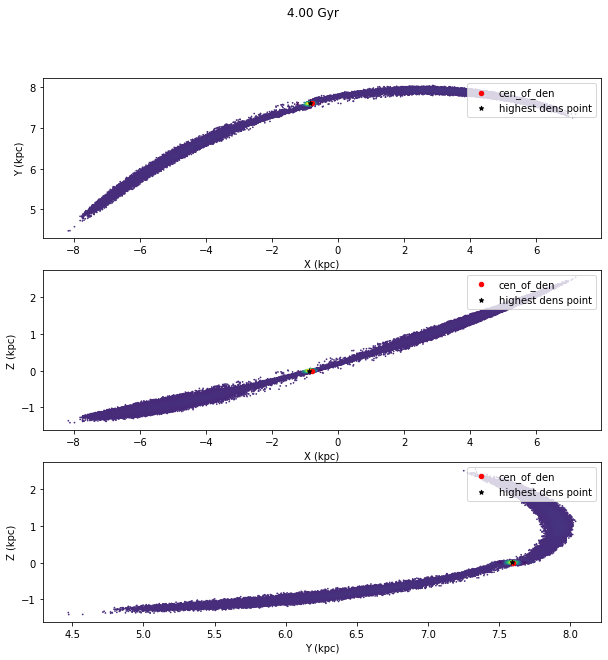

In [32]:
nn = 400
fn = dir1 + "snapshot_{:03d}.hdf5".format(nn) 
galc2,Lmean,xR,yR,zR,vxR,vyR,vzR = align_stream(fn,output_galcoords=True)

xc,yc,zc,_,_,_ = \
find_centre_of_density(xR,yR,zR,vxR,vyR,vzR,0.46*np.ones(len(galc2.x.value)),nmax=5000,rmin=0.1)

xcd,ycd,densxy,_x,_y= compute_surface_density(xR,yR,method="hist",bw=None,bins=[60,60])
x1cd,zcd,densxz,_x1,_z= compute_surface_density(xR,zR,method="hist",bw=None,bins=[60,60])
y1cd,z1cd,densyz,_y1,_z1= compute_surface_density(yR,zR,method="hist",bw=None,bins=[60,60])

plt.figure(figsize=(10,10))
plt.suptitle("{:.2f} Gyr".format(0.01*(nn)))
plt.subplot(3,1,1)
#plt.scatter(galc2.x.value,galc2.y.value,s=0.5,c=densxy)
plt.scatter(_x,_y,s=0.5,c=densxy)
plt.scatter(xc,yc,c='r',s=20,label="cen_of_den")
plt.scatter(xcd,ycd,c='k',s=20,marker="*",label="highest dens point")
#plt.scatter(_xc,_yc,c='b',s=10)
plt.legend(loc="upper right")
#plt.quiver(xcore,ycore,Lmean[0],Lmean[1])
plt.xlabel("X (kpc)")
plt.ylabel("Y (kpc)")
#plt.xlim(-6,6)
#plt.ylim(-6,6)

plt.subplot(3,1,2)
#plt.scatter(galc2.x.value,galc2.z.value,s=0.5,c=densxz)
plt.scatter(_x1,_z,s=0.5,c=densxz)
plt.scatter(xc,zc,c='r',s=20,label="cen_of_den")
#plt.scatter(_xc,_zc,c='b',s=10)
plt.scatter(x1cd,zcd,c='k',s=20,marker="*",label="highest dens point")
#plt.quiver(xcore,zcore,Lmean[0],Lmean[2])
plt.xlabel("X (kpc)")
plt.ylabel("Z (kpc)")
plt.legend(loc="upper right")
#plt.xlim(-6,6)
#plt.ylim(-36,6)

plt.subplot(3,1,3)
#plt.scatter(galc2.x.value,galc2.y.value,s=0.5,c=densxy)
plt.scatter(_y1,_z1,s=0.5,c=densxy)
plt.scatter(yc,zc,c='r',s=20,label="cen_of_den")
plt.scatter(y1cd,z1cd,c='k',s=20,marker="*",label="highest dens point")
#plt.scatter(_xc,_yc,c='b',s=10)
plt.legend(loc="upper right")
#plt.quiver(xcore,ycore,Lmean[0],Lmean[1])
plt.xlabel("Y (kpc)")
plt.ylabel("Z (kpc)")
#plt.savefig("surface_plots/plot_den_back_{}.png".format(nn))
plt.show()

In [33]:
#Once the stream is rotated, it lies almost in z=0 plane, use the azimuthal angle as phi1 
phi1 = np.degrees(np.arctan2(yR,xR))
phi2 = np.degrees(np.arctan2(zR,np.sqrt(xR**2 + yR**2)))

p1core,p2core,densp12,p1,p2= compute_surface_density(phi1,phi2,method="hist",bw=0.01,bins=[60,60])

#bin in phi1 and compute velocity dispersion and density
phi1_bins = np.linspace(phi1.min(),phi1.max(),75)
phi1_mid = [0.5*(phi1_bins[ii]+phi1_bins[ii+1]) for ii in range(len(phi1_bins)-1)]
p1_binned = np.histogram(phi1,bins = phi1_bins)[0]

v_disp =[]
for ii in range(len(phi1_bins)-1):
    _vx = vxR[(phi1 > phi1_bins[ii]) & (phi1 < phi1_bins[ii+1])]
    _vy = vyR[(phi1 > phi1_bins[ii]) & (phi1 < phi1_bins[ii+1])]
    _vz = vzR[(phi1 > phi1_bins[ii]) & (phi1 < phi1_bins[ii+1])]
    v_disp.append(np.sqrt(np.std(_vx)**2 + np.std(_vy)**2 + np.std(_vz)**2))

#print (v_disp)
#print (phi1_bins)

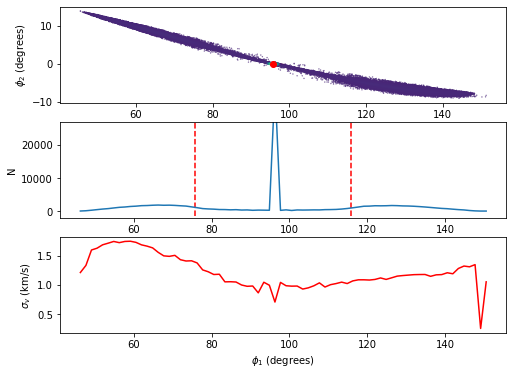

In [34]:
plt.figure(figsize=(8,6))
plt.subplot(3,1,1)
plt.scatter(p1,p2,s=0.1,c=densp12)
plt.scatter(p1core,p2core,color="r")
#plt.xlabel(r"$\phi_{1}$ (degrees)")
plt.ylabel(r"$\phi_{2}$ (degrees)")

plt.subplot(3,1,2)
plt.plot(phi1_mid,p1_binned)
plt.vlines(p1core + 20, -1500,p1_binned.max(),color="r",ls="--")
plt.vlines(p1core - 20, -1500,p1_binned.max(),color="r",ls="--")
#plt.xlabel(r"$\phi_{1}$ (degrees)")
plt.ylim(-2000,27000)
plt.ylabel("N")

plt.subplot(3,1,3)
plt.plot(phi1_mid,v_disp,c='r')
plt.xlabel(r"$\phi_{1}$ (degrees)")
plt.ylabel(r"$\sigma_v$ (km/s)")
plt.show()

In [35]:
#The stream is moving to the right.
#Select leading and trailing arm after excluding 10 deg around the progenitor

#Note the 110 and 80 deg comes from plotting the density and removing the overdense regions around the progenitor

p1_lead = phi1[(phi1 > p1core + 20) & (phi1 < 147.)] 
p1_trail = phi1[(phi1 < p1core - 20) & (phi1 > 47.)]


#print (np.histogram(p1_trail,bins=60))

p1_bin_lead_mid,Ndn_lead,Ndn_lead_err,nden_lead,nden_lead_err,pp_lead = compute_ndenp1(p1_lead,Nbins=64,polydeg=3)
p1_bin_trail_mid,Ndn_trail,Ndn_trail_err,nden_trail,nden_trail_err,pp_trail = compute_ndenp1(p1_trail,Nbins=58,polydeg=3)

bin width = 0.50
25347
bin width = 0.50
25026


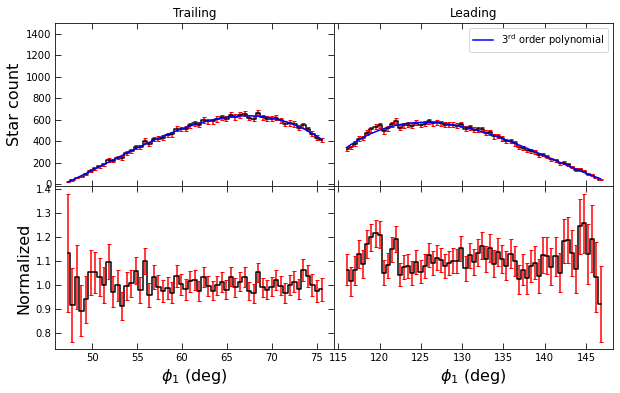

In [36]:
plt.figure(figsize=(10,6))

ax1=plt.subplot(2,2,1)
ax1.set_title("Trailing")
ax1.tick_params(axis='both',direction='in',which='both',top=True,right=True,length=6.,labelbottom=False) 
plt.plot(p1_bin_trail_mid,Ndn_trail,c='k',ds='steps-mid')
plt.errorbar(p1_bin_trail_mid,Ndn_trail,Ndn_trail_err,marker='None',ls='None',capsize=2.,ecolor='r')
#plt.text(0.42,0.85,'Perturbed',fontsize=15,transform=ax2.transAxes)
plt.plot(p1_bin_trail_mid,pp_trail,c='b',label=r'$3^{\rm{rd}}$ order polynomial')
plt.ylim(-20,1500)
plt.xlabel([])
#plt.ylabel([])
#plt.yticks([])
plt.ylabel('Star count',fontsize=16)
#plt.legend(loc='upper right',fontsize=10)


ax2=plt.subplot(2,2,2)
ax2.tick_params(axis='both',direction='in',which='both',top=True,right=True,length=6.,labelbottom=False) 
ax2.set_title("Leading")
plt.plot(p1_bin_lead_mid,Ndn_lead,c='k',ds='steps-mid')
plt.errorbar(p1_bin_lead_mid,Ndn_lead,Ndn_lead_err,marker='None',ls='None',capsize=2.,ecolor='r')
#plt.text(0.42,0.85,'Perturbed',fontsize=15,transform=ax2.transAxes)
plt.plot(p1_bin_lead_mid,pp_lead,c='b',label=r'$3^{\rm{rd}}$ order polynomial')
plt.ylim(-20,1500)
plt.xlabel([])
plt.yticks([])
#plt.ylabel('Star count',fontsize=16)
plt.legend(loc='upper right',fontsize=10)

ax3=plt.subplot(2,2,3)
ax3.tick_params(axis='both',direction='in',which='both',top=True,right=True,left=True,length=6.) 
plt.plot(p1_bin_trail_mid,nden_trail,ds='steps-mid',c='k')
#plt.text(0.28,0.85,r'Divided by $3^{\rm{rd}}$ order polynomial',fontsize=15,transform=ax3.transAxes)
plt.errorbar(p1_bin_trail_mid,nden_trail,nden_trail_err,marker='None',capsize=2.,ls='None',ecolor='r')
#plt.ylim(-1,9.5)
#plt.xlim(0.2,15.)
#plt.yticks([])
plt.xlabel(r'$\phi_{1}$ (deg)',fontsize=16)
plt.ylabel('Normalized',fontsize=16)
plt.subplots_adjust(wspace=0, hspace=0)


ax4=plt.subplot(2,2,4)
ax4.tick_params(axis='both',direction='in',which='both',top=True,right=True,length=6.) 
plt.plot(p1_bin_lead_mid,nden_lead,ds='steps-mid',c='k')
#plt.text(0.28,0.85,r'Divided by $3^{\rm{rd}}$ order polynomial',fontsize=15,transform=ax3.transAxes)
plt.errorbar(p1_bin_lead_mid,nden_lead,nden_lead_err,marker='None',capsize=2.,ls='None',ecolor='r')
#plt.ylim(-1,9.5)
#plt.xlim(0.2,15.)
plt.yticks([])
plt.xlabel(r'$\phi_{1}$ (deg)',fontsize=16)
#plt.ylabel('Normalized',fontsize=16)
plt.subplots_adjust(wspace=0, hspace=0)


#plt.savefig('plots/nden_1010Msun_streamdf_patspeed39.pdf')
plt.show()

In [37]:
px_lead, py_lead, py_lead_err = compute_Pk(p1_bin_lead_mid,nden_lead,nden_lead_err, scaling = 'spectrum')
px_trail, py_trail, py_trail_err = compute_Pk(p1_bin_trail_mid,nden_trail,nden_trail_err, scaling = 'spectrum')

/scratch/user/banik/.conda/envs/galpy1.7/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide



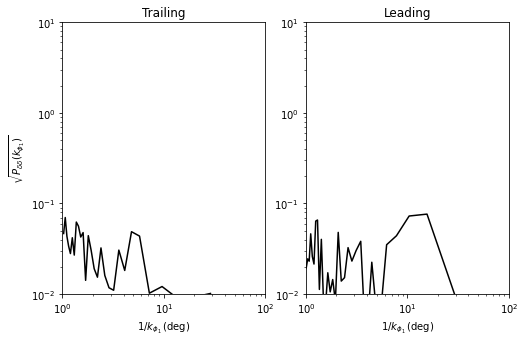

In [38]:
plt.figure(figsize=(8,5))

ax1=plt.subplot(1,2,1)
ax1.set_title("Trailing")
plt.loglog(px_trail, py_trail,color='k')
#loglog(px0,pyerr0,color='g',ls='--',zorder=1)
plt.ylabel(r'$\sqrt{P_{\delta\delta}(k_{\phi_{1}})}$',size=10)
plt.xlabel(r'$1/k_{\phi_{1}}\,(\mathrm{deg})$',size=10)
plt.ylim(0.01,10.)
plt.xlim(1,100.)


ax2=plt.subplot(1,2,2)
ax2.set_title("Leading")
plt.loglog(px_lead, py_lead,color='k')
plt.xlabel(r'$1/k_{\phi_{1}}\,(\mathrm{deg})$',size=10)
plt.ylim(0.01,10.)
plt.xlim(1,100.)

#plt.legend(loc='lower right')
plt.show()

#savefig('plots/power_1mil39_patspeed_streamdf_5Gyrbarpot.pdf')

## 

## Align stream along $\phi_{1}$ and $\phi_{2}$
Compute angular momentum after shifting origin to the Sun and rotate the sky such that the angular momentum points along +z axis 

In [ ]:
#transform Galactocentric coordinates (box frame) to Galactic coordinates
v_sun = coord.CartesianDifferential([11.1, 244, 7.25]*u.km/u.s)

_gc2=coord.Galactocentric(x=-12.73*u.kpc,y=-0.65*u.kpc,z=5.98*u.kpc,v_x=-73.33*(u.km/u.s),\
                     v_y=-210.87*(u.km/u.s),v_z=-100.05*(u.km/u.s),galcen_distance=8.*u.kpc,
                            galcen_v_sun=v_sun,
                            z_sun=0*u.pc)

_gal_c2=_gc2.transform_to(coord.ICRS)
_gal_c2.representation_type = 'cartesian'

_xc = _gal_c2.x.value ; _yc = _gal_c2.y.value ; _zc = _gal_c2.z.value ;
_vxc = _gal_c2.v_x.value ; _vyc = _gal_c2.v_y.value ; _vzc = _gal_c2.v_z.value;

In [ ]:
xcore,ycore,densxy,_x,_y= compute_surface_density(x,y,method="Gaussian",bw=0.01,bins=[20,20])
xcore1,zcore,densxz,_x1,_z= compute_surface_density(x,z,method="Gaussian",bw=0.01,bins=[20,20])
ycore1,zcore1,densxz,_y1,_z1= compute_surface_density(y,z,method="Gaussian",bw=0.01,bins=[20,20])

In [ ]:
xc,yc,zc,_,_,_ =  find_centre_of_density(x,y,z,vx,vy,vz,0.46*np.ones(len(z)))

In [ ]:
#compute angluar momentum with the rotated particle coordinates for plotting
L_rot = []

for ii in range(len(x)):
    L_rot.append(np.cross([x[ii],y[ii],z[ii]],[vx[ii],vy[ii],vz[ii]]))

L_rot = np.array(L_rot)
Lmean = np.mean(L_rot,axis=0)

phi1 = np.degrees(np.arctan2(y,x))
phi2 = np.degrees(np.arctan2(np.sqrt(x**2 + y**2),z))

p1core,p2core,densp12,p1,p2= compute_surface_density(phi1,phi2,method="Gaussian",bw=0.01,bins=[20,20])

#bin in phi1 and compute velocity dispersion and density
phi1_bins = np.linspace(phi1.min(),phi1.max(),61)
phi1_mid = [0.5*(phi1_bins[ii]+phi1_bins[ii+1]) for ii in range(len(phi1_bins)-1)]
p1_binned = np.histogram(phi1,bins = phi1_bins)[0]

v_disp =[]
for ii in range(len(phi1_bins)-1):
    _vx = vx[(phi1 > phi1_bins[ii]) & (phi1 < phi1_bins[ii+1])]
    _vy = vy[(phi1 > phi1_bins[ii]) & (phi1 < phi1_bins[ii+1])]
    _vz = vz[(phi1 > phi1_bins[ii]) & (phi1 < phi1_bins[ii+1])]
    v_disp.append(np.sqrt(np.std(_vx)**2 + np.std(_vy)**2 + np.std(_vz)**2))

print (v_disp)

In [ ]:
plt.figure(figsize=(8,19))
plt.suptitle("{:.2f} Gyr".format(0.01*400))
plt.subplot(6,1,1)
#plt.scatter(galc2.x.value,galc2.y.value,s=0.5,c=densxy)
plt.scatter(_x,_y,s=0.1,c=densxy)
plt.quiver(xc,yc,Lmean[0],Lmean[1],color="r")
#plt.xlabel("X (kpc)")
plt.ylabel("Y (kpc)")
#plt.xlim(-6,6)
#plt.ylim(-6,6)

plt.subplot(6,1,2)
#plt.scatter(galc2.x.value,galc2.z.value,s=0.5,c=densxz)
plt.scatter(_x1,_z,s=0.1,c=densxz)
plt.quiver(xc,zc,Lmean[0],Lmean[2],color="r")
plt.xlabel("X (kpc)")
plt.ylabel("Z (kpc)")

plt.subplot(6,1,3)
#plt.scatter(galc2.x.value,galc2.z.value,s=0.5,c=densxz)
plt.scatter(_y1,_z1,s=0.1,c=densxz)
plt.quiver(yc,zc,Lmean[1],Lmean[2],color="r")
plt.xlabel("Y (kpc)")
plt.ylabel("Z (kpc)")
#plt.xlim(-6,6)
#plt.ylim(-36,6)

#plt.subplot(6,1,4)
#plt.scatter(p1,p2,s=0.1,c=densp12)
#plt.scatter(p1core,p2core,color="r")
#plt.xlabel(r"$\phi_{1}$ (degrees)")
#plt.ylabel(r"$\phi_{2}$ (degrees)")

#plt.subplot(6,1,5)
#plt.plot(phi1_mid,p1_binned)
#plt.xlabel(r"$\phi_{1}$ (degrees)")
#plt.ylabel("N")

#plt.subplot(6,1,6)
#plt.plot(phi1_mid,v_disp,c='r')
#plt.xlabel(r"$\phi_{1}$ (degrees)")
#plt.ylabel(r"$\sigma_v$ (km/s)")
plt.show()
    
    

In [ ]:

print (mean_L)
xcore,ycore,_,_,_= compute_surface_density(gal_c2.x.value,gal_c2.y.value)
_,zcore,_,_,_= compute_surface_density(gal_c2.x.value,gal_c2.z.value)


In [ ]:
print (r_rot[0])

In [ ]:
xcore_rot,ycore_rot,_,_,_= compute_surface_density(r_rot[:,0],r_rot[:,1])
_,zcore_rot,_,_,_= compute_surface_density(r_rot[:,0],r_rot[:,2])

In [ ]:
dir1 = "ics/single_particle/"
tt1,id1,x1,y1,z1,vx1,vy1,vz1,m1,pot1,ax1,ay1,az1 = extract_data_of_ptype(folder=dir1,ptype=4,nfiles=83,shift_file_ind=0,shift_ID=0,pot_acc=True)

  

In [ ]:
def MN_acc(x,y,z,M=5.78,a=3.,b=0.28):
    
    G=43007.1
    R = np.sqrt(x**2 +y**2)
    fac1 = np.sqrt(z**2 + b**2)
    fac = (R**2 + (a + fac1)**2)**(-1.5)
    ax = -G*M*x*fac
    ay = -G*M*y*fac
    az = -G*M*z*(1+a/fac1)*fac
    return (ax,ay,az)



In [ ]:
ax_t = []
ay_t = []
az_t = []
for ii in range(len(m1)):
    ax_t.append(MN_acc(x1[ii],y1[ii],z1[ii])[0][0])
    ay_t.append(MN_acc(x1[ii],y1[ii],z1[ii])[1][0])
    az_t.append(MN_acc(x1[ii],y1[ii],z1[ii])[2][0])
               
plt.figure()
plt.plot(tt1,ax1)
plt.plot(tt1,ax_t,ls="--")
plt.show()

In [ ]:
dir1 = "ics/MW_GB_Mres1e6Msun_GD-1_currentPos_velflipped/"
dir2 = "ics/GD-1_currentPos_velflipped/"

_,_,x4,y4,z4,_,_,_,_,_,ax4,ay4,az4 = extract_data_of_ptype(folder=dir1,ptype=4,nfiles=50,shift_file_ind=0,shift_ID=0,pot_acc=True)
_,_,xa,ya,za,_,_,_,_,_,axa,aya,aza = extract_data_of_ptype(folder=dir2,ptype=4,nfiles=50,shift_file_ind=0,shift_ID=0,pot_acc=True)

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.hist(ax4[3],histtype="step",label='Nbody')
plt.hist(axa[3],histtype="step")
plt.legend(loc="upper right")

plt.subplot(1,3,2)
plt.hist(ay4[3],histtype="step")
plt.hist(aya[3],histtype="step")

plt.subplot(1,3,3)
plt.hist(az4[3],histtype="step")
plt.hist(aza[3],histtype="step")
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.hist(x4[3],histtype="step")
plt.hist(xa[3],histtype="step")

plt.subplot(1,3,2)
plt.hist(y4[3],histtype="step")
plt.hist(ya[3],histtype="step")

plt.subplot(1,3,3)
plt.hist(z4[3],histtype="step")
plt.hist(za[3],histtype="step")
plt.show()



In [ ]:
import amuse

In [ ]:
import matplotlib.pyplot as plt
import h5py
from mpl_toolkits import mplot3d
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord,Galactic,ICRS,Galactocentric
from galpy.orbit import Orbit
from galpy.util import bovy_conversion
from astropy import units as u
from galpy.potential import NFWPotential,MiyamotoNagaiPotential,evaluatePotentials,evaluateRforces,evaluatezforces
from matplotlib import animation
import pynbody
from galpy.util import bovy_conversion#.mass_in_msol
from galpy.potential.mwpotentials import McMillan17
from galpy.util.bovy_conversion import get_physical
from amuse.lab import *
from amuse.couple import bridge
from amuse.datamodel import Particles
from galpy.potential import to_amuse, MWPotential2014
from galpy.util import bovy_plot

def read_snapshot(fname='test.hdf5',read_axes='Coordinates',ptype=1):
    data = h5py.File(fname, 'r')
    group = data['PartType{}'.format(int(ptype))]
    dd=group[read_axes][()]
    
    try:
        if np.size(dd,1) ==3:
            return (dd[:,0],dd[:,1],dd[:,2])
    
    except IndexError:
        return (dd)

def Gizmo_to_pynbody(fn="test.hdf5",ptypes=[1,2,3,4,5],eps_list=[0.1,1.0,1.0,1.0,1.0]):
    '''
    We are going to merge all ptypes to dm
    '''
    x=[]
    y=[]
    z=[]
    vx=[]
    vy=[]
    vz=[]
    m=[] 
    eps=[]
    for pt in ptypes:
        _x,_y,_z = read_snapshot(fname=fn,read_axes='Coordinates',ptype=pt)
        _vx,_vy,_vz = read_snapshot(fname=fn,read_axes='Velocities',ptype=pt)
        _m=read_snapshot(fname=fn,read_axes='Masses',ptype=pt)
        
        _x = _x.tolist()
        _y = _y.tolist()
        _z = _z.tolist()
        _vx = _vx.tolist()
        _vy = _vy.tolist()
        _vz = _vz.tolist()
        _m = _m.tolist()
        
        x.append(_x)
        y.append(_y)
        z.append(_z)
        vx.append(_vx)
        vy.append(_vy)
        vz.append(_vz)
        m.append(_m)
        
        eps.append(np.ones(len(_x),dtype=np.float64).tolist())
        
    x = np.array([item for sublist in x for item in sublist])
    y = np.array([item for sublist in y for item in sublist])
    z = np.array([item for sublist in z for item in sublist])
    vx = np.array([item for sublist in vx for item in sublist])
    vy = np.array([item for sublist in vy for item in sublist])
    vz = np.array([item for sublist in vz for item in sublist])
    m = np.array([item for sublist in m for item in sublist])
    eps = np.array([item for sublist in eps for item in sublist])

    pos1= np.c_[(x,y,z)]
    vel1= np.c_[(vx,vy,vz)]
    
    f = pynbody.snapshot.new(dm=len(m))
    f['pos'] =pynbody.array.SimArray(pos1,"kpc")
    f['vel'] =pynbody.array.SimArray(vel1,'km s**-1')
    f['mass'] =pynbody.array.SimArray(m*1e10,'Msol')
    f['eps'] = pynbody.array.SimArray(eps,'kpc')
    f.physical_units()
    
    return (f)

#ff = Gizmo_to_pynbody(fn="GalactICs_halo_correctedMcMillan.hdf5",ptypes=[1])


#from galpy.util.bovy_conversion import _G
#g= pynbody.array.SimArray(_G/1000.)
#g.units= 'kpc Msol**-1 km**2 s**-2 G**-1'
#ff._arrays['mass']= ff._arrays['mass']*g

#from galpy.potential import InterpSnapshotRZPotential
#spi= InterpSnapshotRZPotential(ff,rgrid=(np.log(0.01),np.log(200.),101),logR=True,zgrid=(0.,10.,101),interpPot=True,zsym=True)

with open("Potential_MWHalo_Mres1e6_physicalunits.pkl",'rb') as savefile:
    spi= pickle.load(savefile,encoding='latin1')


def write_snap(fname,stars,t):
    t=t.value_in(units.Myr)
    fo = open(fname,"w")
    fo.write("#t x  y  z   vx   vy  vz" + "\n")
    for ii in range(len(stars.x)):
        fo.write(str(t) +"  "+str(stars.x.value_in(units.kpc)[ii]) + "  " + str(stars.y.value_in(units.kpc)[ii]) + "  " + str(stars.z.value_in(units.kpc)[ii]) + "  " + \
        str(stars.vx.value_in(units.km/units.s)[ii]) +"   "+ str(stars.vy.value_in(units.km/units.s)[ii]) +"   "+ str(stars.vz.value_in(units.km/units.s)[ii]) +"\n")
    fo.close()
    return None

# Convert galpy potential to AMUSE representation
mwp_amuse= to_amuse(spi)

#offsets to move the cluster to its initial location
xoff = -12.899949768688582
yoff = -0.6519411336112366
zoff = 5.985034975860925
vxoff = -75.20280798826663
vyoff = -224.22651691603198
vzoff = -100.52334332515584

#convert cluster to AMUSE container
dat_init = np.loadtxt("gd1_N16W2R20_eps2pc.dat")

xi=(dat_init[:,1]*0.001)
yi=(dat_init[:,2]*0.001) 
zi=(dat_init[:,3]*0.001)
vxi=(dat_init[:,4]) 
vyi=(dat_init[:,5]) 
vzi=(dat_init[:,6]) 
m = 0.46*np.ones(len(dat_init[:,1])) 

stars = Particles(len(xi))
stars.x=xi| units.kpc
stars.y=yi| units.kpc
stars.z=zi| units.kpc
stars.vx=vxi| units.km/units.s
stars.vy=vyi| units.km/units.s
stars.vz=vzi| units.km/units.s
stars.mass=m| units.MSun

Rcluster = max(np.sqrt(xi**2 + yi**2 +zi**2))|units.kpc
Mcluster = np.sum(m)|units.MSun
Rinit= [xoff,yoff,zoff] | units.kpc
Vinit= [vxoff,vyoff,vzoff] | units.km/units.s

converter= nbody_system.nbody_to_si(Mcluster,Rcluster)
stars.x+= Rinit[0]
stars.y+= Rinit[1]
stars.z+= Rinit[2]
stars.vx+= Vinit[0]
stars.vy+= Vinit[1]
stars.vz+= Vinit[2]

# Setup star cluster simulation
tend= 1.0 | units.Gyr
#dtout= 2.0 | units.Gyr
dt= 0.973*0.01 | units.Gyr   #Gizmo time

# Setup cluster
cluster_code= BHTree(converter,number_of_workers=28) #Change number of workers depending no. of CPUs
cluster_code.parameters.epsilon_squared= (3. | units.parsec)**2
cluster_code.parameters.opening_angle= 0.6
cluster_code.parameters.timestep= dt
cluster_code.particles.add_particles(stars)

# Setup channels between stars particle dataset and the cluster code
channel_from_stars_to_cluster_code= stars.new_channel_to(cluster_code.particles,attributes=["mass", "x", "y", "z", "vx", "vy", "vz"])
channel_from_cluster_code_to_stars= cluster_code.particles.new_channel_to(stars,attributes=["mass", "x", "y", "z", "vx", "vy", "vz"])

# Setup gravity bridge
gravity= bridge.Bridge(use_threading=False)
# Stars in cluster_code depend on gravity from external potential mwp_amuse (i.e., MWPotential2014)
gravity.add_system(cluster_code, (mwp_amuse,))
# External potential mwp_amuse still needs to be added to system so it evolves with time
gravity.add_system(mwp_amuse,)
# Set how often to update external potential
gravity.timestep= cluster_code.parameters.timestep/2.
# Evolve
time= 0.0 | tend.unit

n= 0 
snap_dir = "amuse_snaps/"

#write 0th snap
write_snap(snap_dir + "snap_{:03d}.dat".format(n),stars,time)


while time<tend:
    gravity.evolve_model(time+dt)
    # If you want to output or analyze the simulation, you need to copy
    # stars from cluster_code
    channel_from_cluster_code_to_stars.copy()
    # If you edited the stars particle set, for example to remove stars from the
    # array because they have been kicked far from the cluster, you need to
    # copy the array back to cluster_code:
    #channel_from_stars_to_cluster_code.copy()
    n+=1
    write_snap(snap_dir + "snap_{:03d}.dat".format(n),stars,time+dt)
    
    # Update time
    time= gravity.model_time
    









In [ ]:
from amuse.lab import *
from amuse.couple import bridge
from amuse.datamodel import Particles
from galpy.potential import to_amuse, MWPotential2014
from galpy.util import bovy_plot
# Convert galpy MWPotential2014 to AMUSE representation
mwp_amuse= to_amuse(MWPotential2014)

# Set initial cluster parameters
N= 1000
Mcluster= 1000. | units.MSun
Rcluster= 10. | units.parsec
Rinit= [10.,0.,0.] | units.kpc
Vinit= [0.,220.,0.] | units.km/units.s
# Setup star cluster simulation
tend= 100.0 | units.Myr
dtout= 5.0 | units.Myr
dt= 1.0 | units.Myr

def setup_cluster(N,Mcluster,Rcluster,Rinit,Vinit):
    converter= nbody_system.nbody_to_si(Mcluster,Rcluster)
    stars= new_plummer_sphere(N,converter)
    stars.x+= Rinit[0]
    stars.y+= Rinit[1]
    stars.z+= Rinit[2]
    stars.vx+= Vinit[0]
    stars.vy+= Vinit[1]
    stars.vz+= Vinit[2]
    return stars,converter

# Setup cluster
stars,converter= setup_cluster(N,Mcluster,Rcluster,Rinit,Vinit)
cluster_code= BHTree(converter,number_of_workers=4) #Change number of workers depending no. of CPUs
cluster_code.parameters.epsilon_squared= (3. | units.parsec)**2
cluster_code.parameters.opening_angle= 0.6
cluster_code.parameters.timestep= dt
cluster_code.particles.add_particles(stars)
# Setup channels between stars particle dataset and the cluster code
channel_from_stars_to_cluster_code= stars.new_channel_to(cluster_code.particles,
                                        attributes=["mass", "x", "y", "z", "vx", "vy", "vz"])
channel_from_cluster_code_to_stars= cluster_code.particles.new_channel_to(stars,
                                        attributes=["mass", "x", "y", "z", "vx", "vy", "vz"])

# Setup gravity bridge
gravity= bridge.Bridge(use_threading=False)
# Stars in cluster_code depend on gravity from external potential mwp_amuse (i.e., MWPotential2014)
gravity.add_system(cluster_code, (mwp_amuse,))
# External potential mwp_amuse still needs to be added to system so it evolves with time
gravity.add_system(mwp_amuse,)
# Set how often to update external potential
gravity.timestep= cluster_code.parameters.timestep/2.
# Evolve
time= 0.0 | tend.unit
while time<tend:
    gravity.evolve_model(time+dt)
    # If you want to output or analyze the simulation, you need to copy
    # stars from cluster_code
    #channel_from_cluster_code_to_stars.copy()
    # If you edited the stars particle set, for example to remove stars from the
    # array because they have been kicked far from the cluster, you need to
    # copy the array back to cluster_code:
    #channel_from_stars_to_cluster_code.copy()

    # Update time
    time= gravity.model_time
channel_from_cluster_code_to_stars.copy()
gravity.stop()
bovy_plot.bovy_plot(stars.x.value_in(units.kpc),stars.y.value_in(units.kpc),'.',
                     xlabel=r'$X\,(\mathrm{kpc})$',ylabel=r'$Y\,(\mathrm{kpc})$')

In [ ]:
import pickle
sdf='mockgd1_pepper_leading_Plummer_sigv0.46_td4.0_86sampling_InterpSphPotAnalyticDisk.pkl'
arm='leading'

with open(sdf,'rb') as savefile:
        sdf_smooth= pickle.load(savefile,encoding='latin1')
        sdf_pepper= pickle.load(savefile,encoding='latin1')


In [ ]:
import random
print (random.randint(100,100000))

In [5]:
dir1 = "../Gizmo/ics/GD1_inMcMillanHaloVelFlipped_Mres1e5_Disk_N100W7R20_forward_integrate/"

mm = 1
mm_shift = 0

tt1,id1,x1,y1,z1,vx1,vy1,vz1,m1 = extract_data_of_ptype(folder=dir1,ptype=1,nfiles=mm,shift_file_ind=mm-1,shift_ID=0,pot_acc=False)

r1 = np.sqrt(x1[0]**2 + y1[0]**2 +z1[0]**2)

print (len(r1[(r1 >=5.)&(r1 <=17.)]))

1081022


In [4]:
from scipy import integrate

def dndM_cdm(M,c0kpc=2.02*10**(-13),mf_slope=-1.9):
    #c0kpc=2.02*10**(-13) #Msun^-1 kpc^-3 from Denis' paper
    m0=2.52*10**7 #Msun from Denis' paper
    return c0kpc*((M/m0)**mf_slope)

def Einasto(r):
    al=0.678 #alpha_shape
    rm2=199 #kpc, see Erkal et al 1606.04946 for scaling to M^1/3
    return np.exp((-2./al)*((r/rm2)**al -1.))*4*np.pi*(r**2)

def totalN(M1,M2,r=20.,c0kpc=2.02*10**(-13),mf_slope=-1.9):
    #number density of subhalos in kpc^-3
    m1=10**(M1)
    m2=10**(M2)
    return integrate.quad(dndM_cdm,m1,m2,args=(c0kpc,mf_slope))[0]*integrate.quad(Einasto,0.,r)[0]

print (totalN(5.,9.,r=17.))

205.4524978528273
